HomeWork1. Data-driven-подход на примере задачи маршрутизации заявок в helpdesk

In [55]:
#Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import os

In [56]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [58]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [59]:
#1. Какое соотношение мужчин и женщин в представленном наборе данных?
#Женщин и мужчин примерно поровну в выборке, переменная gender имеет тип string
data['gender'].value_counts(normalize = True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

In [60]:
#2. Какое количество уникальных значений у поля InternetService?
data['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [61]:
#У атрибута InternetService 3 уникальных значения со следующим распределением: Fiber optic - 0.439%, DSL - 0.343%, No - 0.216%.
data['InternetService'].value_counts(normalize = True)

Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64

In [62]:
#3. Выведите статистики по полю TotalCharges (median, mean, std).
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.describe()['TotalCharges']

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

In [67]:
#4. Сделайте замену значений поля PhoneService на числовые (Yes->1, No->0)
data['PhoneService'] = data['PhoneService'].apply(lambda x: 1 if x == 'Yes' else 0)
data['PhoneService'].head()

0    0
1    1
2    1
3    0
4    1
Name: PhoneService, dtype: int64

In [64]:
#5. Сделайте замену пробелов в поле TotalCharges на np.nan и приведите поле к типу данных float32. Затем заполните оставшиеся
#пропуски значением 0 с помощью метода fillna у столбца. Снова выведите статистики и сравните с тем, что вы видели в вопросе 3.
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
sorted(data['TotalCharges'].tolist())

[' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '100.2',
 '100.25',
 '100.35',
 '100.4',
 '100.8',
 '100.9',
 '1001.2',
 '1001.5',
 '1003.05',
 '1004.35',
 '1004.5',
 '1004.75',
 '1005.7',
 '1006.9',
 '1007.8',
 '1007.9',
 '1008.55',
 '1008.7',
 '1008.7',
 '1009.25',
 '101.1',
 '101.45',
 '101.65',
 '101.9',
 '1010',
 '1011.05',
 '1011.5',
 '1011.8',
 '1012.4',
 '1013.05',
 '1013.2',
 '1013.35',
 '1013.6',
 '1014.25',
 '1016.7',
 '1017.35',
 '102.45',
 '102.5',
 '102.75',
 '1020.2',
 '1020.75',
 '1021.55',
 '1021.75',
 '1021.8',
 '1022.5',
 '1022.6',
 '1022.95',
 '1023.75',
 '1023.85',
 '1023.9',
 '1023.95',
 '1024',
 '1024.65',
 '1024.7',
 '1025.05',
 '1025.15',
 '1025.15',
 '1025.95',
 '1026.35',
 '1027.25',
 '1028.75',
 '1028.9',
 '1029.35',
 '1029.75',
 '1029.8',
 '103.7',
 '1031.1',
 '1031.4',
 '1031.7',
 '1032',
 '1032.05',
 '1033',
 '1033.9',
 '1033.95',
 '1035.5',
 '1035.7',
 '1036',
 '1036.75',
 '1037.75',
 '1039.45',
 '104.2',
 '104.3',
 '1041.8',
 '1042.65

In [68]:
data['TotalCharges'] = data['TotalCharges'].apply(lambda x: np.nan if x == ' ' else x)
data['TotalCharges'] = data['TotalCharges'].fillna(0)
data['TotalCharges'] = data['TotalCharges'].astype(float)

mean = data['TotalCharges'].mean()
median = data['TotalCharges'].median()
std = data['TotalCharges'].std()
print(f'Mean: {mean} \nMedian: {median} \nStd: {std}')

Mean: 2279.734303563826 
Median: 1394.55 
Std: 2266.7944696890195


In [66]:
#Метод to_numeric преобразовывает пробелы в Nan, в результате значения медианы, среднего и отклонения оказываются смещенными.
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.describe()['TotalCharges']

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

In [69]:
#6. Сделайте замену значений поля Churn на числовые (Yes -> 1, No - 0)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
data['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [70]:
#7. Сделайте замену значений полей StreamingMovies, StreamingTV, TechSupport на числовые
#(Yes -> 1, No -> 0, No internet service->0)
col = ['StreamingMovies', 'StreamingTV', 'TechSupport']
for c_ in col:
    data[c_] = data[c_].apply(lambda x: 1 if x == 'Yes' else 0)
    
data.describe()

,SeniorCitizen,tenure,PhoneService,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,0.903166,0.290217,0.384353,0.387903,64.761692,2279.734304,0.265370
std,0.368612,24.559481,0.295752,0.453895,0.486477,0.487307,30.090047,2266.794470,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [71]:
#8. Заполните пропуски в поле PhoneService значением 0
data['PhoneService'].value_counts()

1    6361
0     682
Name: PhoneService, dtype: int64

In [72]:
#Разве в этом поле есть пропуски?
data[(data['PhoneService'] != 1) & (data['PhoneService'] != 0)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [73]:
#8. Для нашего датасета оставьте только указанный ниже список полей, удалив все другие и выведите верхние 3 строки:
columns = ['gender', 'tenure', 'PhoneService', 'TotalCharges', 
           'StreamingMovies', 'StreamingTV', 'TechSupport', 'Churn']
data = data[columns]
data.head(3)

,gender,tenure,PhoneService,TotalCharges,StreamingMovies,StreamingTV,TechSupport,Churn
0,Female,1,0,29.85,0,0,0,0
1,Male,34,1,1889.50,0,0,0,0
2,Male,2,1,108.15,0,0,0,1


In [74]:
#9. Разделите датасет на тренировочную и тестовую выборку.
features = ['gender', 'tenure', 'PhoneService', 'TotalCharges', 'StreamingMovies', 'StreamingTV', 'TechSupport']
target = 'Churn'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [75]:
#10. соберите pipeline для поля gender (нужно разобраться и изучить https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html )
#из классов ColumnSelector и OHEEncoder, которые уже написаны ниже заранее:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [76]:
pipeline = Pipeline([
     ('title_selector', ColumnSelector(key='gender')), 
     ('encoder', OHEEncoder(key = 'gender'))], verbose=True)

In [77]:
#11. Вызовите метод fit_transform у пайплайна gender и передайте туда нашу тренировочную выборку (пример по ссылке из
#документации https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.fit)
gender = Pipeline([
     ('title_selector', ColumnSelector(key='gender')), 
     ('encoder', OHEEncoder(key = 'gender'))], verbose=True)
#gender.fit_transform(X_test)

In [78]:
#12. Здесь код писать уже не нужно (все сделано за вас). К полю tenure применяем StandardScaler (нормируем и центрируем).
#Ссылка - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
#Вопрос - в каких случаях это может быть полезно?

#масштабирование признаков обычно делают, когда для решения задачи применяют метрические алгоритмы.

from sklearn.preprocessing import StandardScaler

tenure =  Pipeline([
                ('selector', NumberSelector(key='tenure')),
                ('standard', StandardScaler())
            ])

In [79]:
#13. Напишите аналогичный (как для tenure) преобразователь поля TotalCharges
TotalCharges =  Pipeline([
                ('selector', NumberSelector(key='TotalCharges')),
                ('standard', StandardScaler())
            ])

In [80]:
#Объединение всех "кубиков" очень легко сделать таким образом
from sklearn.pipeline import FeatureUnion

number_features = Pipeline([
                ('selector', ColumnSelector(key=['PhoneService',
                                                 'StreamingMovies', 'StreamingTV', 
                                                 'TechSupport']))
            ])

gender = Pipeline([
     ('title_selector', ColumnSelector(key='gender')), 
     ('encoder', OHEEncoder(key = 'gender'))], verbose=True)

feats = FeatureUnion([('tenure', tenure),
                      ('TotalCharges', TotalCharges),
                      ('continuos_features', number_features),
                      ('gender', gender)])
feature_processing = Pipeline([('feats', feats)])

In [81]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

pipeline.fit(X_train, y_train)

[Pipeline] .... (step 1 of 2) Processing title_selector, total=   0.0s
[Pipeline] ........... (step 2 of 2) Processing encoder, total=   0.0s


C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('tenure',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='tenure')),
                                                                 ('standard',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('TotalCharges',
                                                 Pipeline(memory=None,
                        

In [82]:
# 14. Сделайте прогноз вероятности оттока для X_test с помощью нашего предобученного на предыдущем шаге пайплайна и убедитесь
#что вам возвращаются вероятности для 2 классов:
pipeline.predict_proba(X_test)

array([[1. , 0. ],
       [0.4, 0.6],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [0.7, 0.3],
       [0.9, 0.1]])

Text(0.5,1,'Roc curve with roc auc score: 0.75')

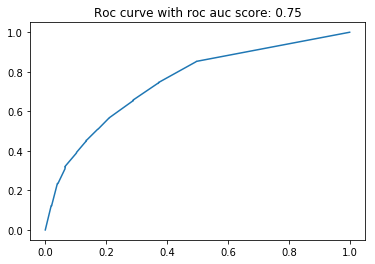

In [83]:
# Посчитайте метрики качества получившейся модели (roc_auc):
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, trs = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.title(f'Roc curve with roc auc score: {round(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1]),2)}')

In [ ]:
#Сохраним наш пайплайн
import dill
with open("model_RF.dill", "wb") as f:
    dill.dump(pipeline, f)